In [17]:

#Import Libraries
import pandas as pd
import numpy as np
import xarray as xr
import os
import cv2
import matplotlib
from scipy.ndimage import gaussian_filter
import datetime
from datetime import date, timedelta
import wget
from math import floor
from pydap.client import open_url
import netCDF4 as nc
import matplotlib.pyplot as plt

matplotlib.use('Agg')    #por causa do erro AttributeError: 'NoneType' object has no attribute 'set_cursor'
%matplotlib inline

In [8]:

######################################### IMPORT DATA #######################################################

def get_data(data):
    
    """
    Function to get our netCDF file that is stored in the data directory and convert it to a dataframe.
    The data parameter is the string name of the netCDF file we want to import
    """
    
    current_path = os.getcwd()
    data_folder = os.path.join(current_path,"../data")
    
    nc_path = os.path.join(data_folder, data)
    ds = nc.Dataset(nc_path)
    netCDF = xr.load_dataset(nc_path)
    
    df = netCDF.to_dataframe()
    df = df.reset_index()
    
    df = df.drop(['depth'], axis=1, errors='ignore') #drop the column 'depth' if exists: only exists in reanalysis
    
    #if MUR data, rename columns and convert temperature to Celsius (the data must be saved as 'mur...nc')
    if data.startswith('mur') or data.startswith('sst'):
        df.rename(columns={'lat': 'latitude', 'lon': 'longitude', 'time': 'time', 'analysed_sst':'thetao'}, inplace=True)
        df['thetao'] = df['thetao']-273.15   
        
    
    return df

In [9]:
df_ex = get_data('sst_20220615.nc')

In [10]:
df_ex

,latitude,longitude,time,thetao
0,35.0,-19.000000,2022-06-15 09:00:00,19.606995
1,35.0,-18.990000,2022-06-15 09:00:00,19.595001
2,35.0,-18.980000,2022-06-15 09:00:00,19.583008
3,35.0,-18.969999,2022-06-15 09:00:00,19.571991
4,35.0,-18.959999,2022-06-15 09:00:00,19.559998
...,...,...,...,...
1402396,45.0,-5.040000,2022-06-15 09:00:00,18.338013
1402397,45.0,-5.030000,2022-06-15 09:00:00,18.338989
1402398,45.0,-5.020000,2022-06-15 09:00:00,18.339996
1402399,45.0,-5.010000,2022-06-15 09:00:00,18.339996


In [86]:

#################################### CANNY ALGORITHM ##########################################################


# Convert the df to a numpy array with the SST values for the coordinate pair (longitude and latitude)
sst = df_ex.pivot_table(index='longitude', columns='latitude', values='thetao').T.values
#Convert Temperature values to uint8 format with values in the range of 0-255
sst_final = ((sst - np.nanmin(sst)) * (1/(np.nanmax(sst) - np.nanmin(sst)) * 255)).astype('uint8')
sst_final = np.flipud(sst_final)   #flipud -> Reverse the order of elements along axis 0 (up/down).
#in case we want to apply a gaussian filter with a certain sigma value (by default is 0)
sst_final = gaussian_filter(sst_final, sigma=5)   


#apply the canny algorithm and plot the image with the edges
canny = cv2.Canny(sst_final, 120, 220, apertureSize=5, L2gradient=False)

canny[canny == 255] = 1


#Apply a mask for the continental zone:
mask = np.isnan(np.flipud(sst))    #Boolean array: True where array Temp had Null Values (correspond to the continental zone)
#mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which values= 255 when mask=True
#Dilation to ensure that the pixels that belong to the "shore/continental zone" are not considered fronts 
#kernel = np.ones((3,3), np.uint8)
#mask_dilated = cv2.dilate(mask255, kernel)
canny_front = np.ma.masked_array(canny, mask)   #Mask an array where a condition is True

#canny_front.astype(np.float)

canny_front = np.flipud(canny_front) 

    

In [81]:
canny_front

masked_array(
  data=[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., --, --, --],
        [0, 0, 0, ..., --, --, --],
        [0, 0, 0, ..., --, --, --]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=999999,
  dtype=uint8)

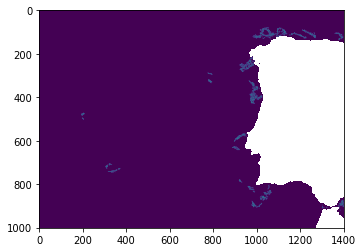

In [82]:
plt.imshow(canny_front)

(array([[1001.,    0.,    0., ...,    0.,    0.,    0.],
        [1001.,    0.,    0., ...,    0.,    0.,    0.],
        [1001.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [ 984.,    0.,    0., ...,    0.,    0.,   17.],
        [ 987.,    0.,    0., ...,    0.,    0.,   14.],
        [ 987.,    0.,    0., ...,    0.,    0.,   14.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 1401 Lists of Patches objects>)

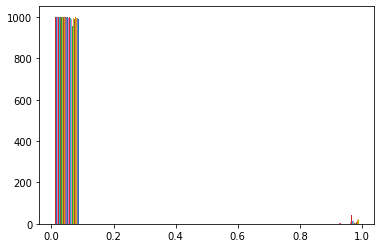

In [79]:
plt.hist(canny_front)

In [57]:
type(canny_front)

numpy.ma.core.MaskedArray

In [58]:
np.info(canny_front)

class:  MaskedArray
shape:  (1001, 1401)
strides:  (1401, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0xb9326f0
byteorder:  little
byteswap:  False
type: uint8


In [80]:
np.unique(canny_front)

masked_array(data=[0, 1, --],
             mask=[False, False,  True],
       fill_value=999999,
            dtype=uint8)

In [87]:

    
base_path = os.getcwd()
base_path = os.path.join(base_path, '../JUNO')      #servidor
# base_path = os.path.join(base_path, 'JUNO')               #minha maquina

#download MUR data for the day before yesterday
day_txt = (date.today() - timedelta(days=2)).strftime('%Y%m%d')


exist_path = os.path.exists(os.path.join(base_path, 'data/MUR_daily_fronts_netcdf'))    #check if folder MUR_algorithm_daily_images exists in data folder
if not exist_path:                                                                         #if doesn't exist
    os.makedirs(os.path.join(base_path, 'data/MUR_daily_fronts_netcdf'))                # create the folder

    
nc_file = os.getcwd()
nc_file = os.path.join(nc_file, '../JUNO/data/MUR_daily_fronts_netcdf/MUR' + day_txt + '.nc')

ds = nc.Dataset(nc_file, 'w', format='NETCDF4')

ds.title = 'MUR ' + day_txt + ' Fronts Arrays'

#create dimensions of the NetCDF file
time = ds.createDimension('time')
lat = ds.createDimension('lat', 1001)
lon = ds.createDimension('lon', 1401)

times = ds.createVariable('time', 'f4', ('time', ))
lats = ds.createVariable('lat', 'f4', ('lat', ))
lons = ds.createVariable('lon', 'f4', ('lon', ))


canny = ds.createVariable('canny', 'f4', ('time', 'lat', 'lon',))
canny.units = 'Unknown'
canny.description = 'Binary Array with identyfied fronts through Canny from OpenCV (1-> front), (0->not front)'
canny[0, :, :] = canny_front.astype(float)

times.units = 'days since 1-1-1'

lats[:] = np.linspace(35, 45, 1001)
lons[:] = np.linspace(-19, -5, 1401)


date_obj = datetime.datetime.strptime(day_txt, '%Y%m%d')
date_time = date_obj.toordinal()
times[:] = date_time

ds.close()


